<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2019/blob/master/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

In [0]:
#Metrics
def mean_square_error(y, y_pred):
    return np.mean(np.square(y - y_pred))

def root_mean_square_error(y, y_pred):
    return mean_square_error(y, y_pred)**0.5
  
def r2_score(y, y_pred):
    y_avg = y.mean()
    ss_total = np.sum(np.square(y - y_avg))
    ss_err = np.sum(np.square(y - y_pred))
    return 1 - ss_err/ss_total

In [0]:
#Utils
def add_biases(X):
    return np.hstack((X, np.ones((X.shape[0],1))))
  
def linear(X, w):
    return np.matmul(w, X.T)
  
def preprocess(X_train, X_test):
    #Standardize
    X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - X_mean)/X_std
    X_test = (X_test - X_mean)/X_std
    
    #Biases
    X_train = add_biases(X_train)
    X_test = add_biases(X_test)
    
    return X_train, X_test

In [0]:
#SGD  
def compute_gradient_on_batch(X, y, w):
  
    batch_size, feature_count = X.shape
    grad = np.zeros((batch_size, feature_count))
    
    for i in range(batch_size):
        grad[i, :] = X[i, :]*(w @ X[i] - y[i])
    
    return grad

def stochastic_gradient_descent(X, y, lr=1e-2, max_epoch=10, 
                                batch_size=1):
    weight_dist = np.inf
    w = np.random.randn(X.shape[1])    #init w
    errors = []
    
    iters = X.shape[0] // batch_size
    if (X.shape[0] % batch_size > 0):
        iters += 1
    
    for epoch in range(max_epoch):
        
        p = np.random.permutation(X.shape[0])
        X, y = X[p], y[p]    #Shuffle

        for i in range(iters):
            
            X_batch = X[i*batch_size:(i+1)*batch_size]
            y_batch = y[i*batch_size:(i+1)*batch_size]

            grad = compute_gradient_on_batch(X_batch, y_batch, w)
            w = w - lr * np.mean(grad, axis=0)
            
        errors.append(mean_square_error(y, linear(X, w)))
    
    return w, errors


In [0]:
#Folds
class KFolds:
    def __init__(self, X, y, k=5):
      
        self.k = k

        self.X_folds = [X[i::k] for i in range(k)]
        self.y_folds = [y[i::k] for i in range(k)]
        
    def get_fold(self, fold_i):
        
        X_cv = self.X_folds[fold_i]
        y_cv = self.y_folds[fold_i]
        
        X_train = np.concatenate([self.X_folds[i] for i in range(self.k) if i != fold_i])
        y_train = np.concatenate([self.y_folds[i] for i in range(self.k) if i != fold_i])
        
        return X_train, y_train, X_cv, y_cv

In [6]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip
!unzip -q Dataset.zip

--2019-09-26 08:39:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19055526 (18M) [application/x-httpd-php]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  18.17M  48.3MB/s    in 0.4s    

2019-09-26 08:39:13 (48.3 MB/s) - ‘Dataset.zip’ saved [19055526/19055526]



In [0]:
import random
train_df = pd.read_csv('Dataset/Training/Features_Variant_1.csv',header=None)
train_df.drop(columns=[37], inplace=True) #drop constant column

data = train_df.values
random.shuffle(data)
y = data[:,-1]
X = data[:,:-1]

In [0]:
test_df = pd.read_csv('Dataset/Testing/Features_TestSet.csv',header=None)
test_df.drop(columns=[37], inplace=True)  #drop constant column

y_test = test_df.values[:,-1]
X_test = test_df.values[:,:-1]

_, X_test = preprocess(X,X_test)

In [0]:
kfold = KFolds(X,y,k=5)

rmse_list = []
r2_list = []
rmse_test_list = []
r2_test_list = []

weights_list = []
errors_list = []

for i in range(kfold.k):
    X_train, y_train, X_cv, y_cv = kfold.get_fold(i)
    X_train, X_cv = preprocess(X_train, X_cv)
    
    w, errors = stochastic_gradient_descent(X_train, y_train, lr=1e-2, max_epoch=20, batch_size=1000)
    errors_list.append(errors)
    weights_list.append(w)

    #Metrics on cv set
    y_pred = linear(X_cv, w)        
    rmse_list.append(root_mean_square_error(y_cv, y_pred))
    r2_list.append(r2_score(y_cv, y_pred))
    
    #Metrics on test set
    y_pred = linear(X_test, w)        
    rmse_test_list.append(root_mean_square_error(y_test, y_pred))
    r2_test_list.append(r2_score(y_test, y_pred))

In [15]:
print("Folds\t│{}\t{}\t{}\t{}\t{}\t│mean\tstd".format(*range(1,kfold.k+1)))
print("────────┼───────────────────────────────────────┼─────────────")
print("        │CV                                     │")
print("────────┼───────────────────────────────────────┼─────────────")
print("RMSE\t│{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}\t│{:.2f}\t{:.2f}".format(*rmse_list, np.array(rmse_list).mean(), np.array(rmse_list).std()))
print("R2\t│{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t│{:.3f}\t{:.3f}".format(*r2_list, np.array(r2_list).mean(), np.array(r2_list).std()))
print("────────┼───────────────────────────────────────┼─────────────")
print("        │Test                                   │")
print("────────┼───────────────────────────────────────┼─────────────")
print("RMSE\t│{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}\t│{:.2f}\t{:.2f}".format(*rmse_test_list, np.array(rmse_test_list).mean(), np.array(rmse_test_list).std()))
print("R2\t│{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t│{:.3f}\t{:.3f}".format(*r2_test_list, np.array(r2_test_list).mean(), np.array(r2_test_list).std()))

Folds	│1	2	3	4	5	│mean	std
────────┼───────────────────────────────────────┼─────────────
        │CV                                     │
────────┼───────────────────────────────────────┼─────────────
RMSE	│31.7	26.4	31.6	30.2	34.9	│30.98	2.76
R2	│0.325	0.419	0.367	0.431	0.345	│0.377	0.041
────────┼───────────────────────────────────────┼─────────────
        │Test                                   │
────────┼───────────────────────────────────────┼─────────────
RMSE	│106.6	106.7	106.4	106.6	107.5	│106.73	0.38
R2	│0.142	0.140	0.144	0.142	0.127	│0.139	0.006


In [0]:
feature_names = [
    "page_likes","page_checkins","page_returns","page_category",
    "X","X.1","X.2","X.3","X.4","X.5","X.6","X.7","X.8","X.9","X.10","X.11","X.12","X.13","X.14","X.15","X.16","X.17","X.18","X.19","X.20","X.21","X.22","X.23","X.24",
    "commBase","comm24","comm48","comm24_1","diff_24.48",
    "base_time","post_length","post_shares","hrs",
    "sun_pub","mon_pub","tue_pub","wed_pub","thu_pub","fri_pub","sat_pub",
    "sun_base","mon_base","tue_base","wed_base","thu_base","fri_base","sat_base"
]

In [17]:
weights_list = np.array(weights_list)
print("────────┼───────────────────────────────────────┼─────────────")
for feat in range(weights_list.shape[1]-1):
    print("{}\t│{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t│ {}".format(feat+1, *weights_list[:,feat], feature_names[feat]))
print("bias\t│{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t│".format(*weights_list[:,-1]))

────────┼───────────────────────────────────────┼─────────────
1	│0.466	1.215	-0.132	0.242	0.982	│ page_likes
2	│-0.910	-0.511	-0.764	-0.458	-0.305	│ page_checkins
3	│-1.267	-1.833	-0.908	-1.525	-2.409	│ page_returns
4	│-0.457	-0.490	-0.512	-0.445	-0.364	│ page_category
5	│0.626	0.304	-0.165	-0.314	-0.999	│ X
6	│0.837	2.132	1.728	0.932	0.099	│ X.1
7	│2.273	1.722	1.442	-0.730	0.787	│ X.2
8	│0.443	-0.339	-0.255	-0.237	-0.094	│ X.3
9	│2.187	2.127	1.340	1.135	2.347	│ X.4
10	│-0.910	-1.512	-0.847	-2.285	-1.817	│ X.5
11	│0.637	-1.535	-1.664	-0.842	-0.380	│ X.6
12	│1.815	1.150	1.237	1.049	0.733	│ X.7
13	│2.826	3.202	2.515	3.428	3.260	│ X.8
14	│-0.711	1.048	-0.367	1.148	0.320	│ X.9
15	│-0.107	-0.078	-0.002	0.085	-0.002	│ X.10
16	│-0.455	-1.082	0.327	0.293	0.026	│ X.11
17	│1.101	0.198	0.453	1.041	0.737	│ X.12
18	│0.820	1.571	2.172	0.945	1.186	│ X.13
19	│1.544	0.851	0.594	0.661	2.212	│ X.14
20	│-0.698	-0.659	-1.333	0.440	1.286	│ X.15
21	│-0.644	-1.218	-1.072	-0.081	-0.905	│ X.16
22	│-1.169	-0.27

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


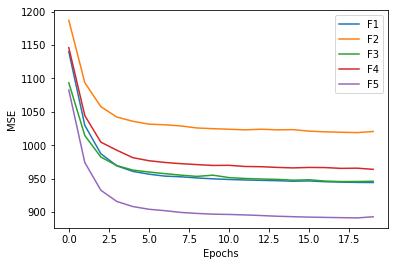

In [18]:
%pylab inline
errors_list = np.array(errors_list)
plt.plot(errors_list.T)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(['F1','F2','F3','F4','F5']);